In [1]:

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:

# Load stocks returns data
stocks_df = pd.read_csv('data/optimal_portfolio_returns.csv', parse_dates=['Date'])
stocks_df = stocks_df.sort_values(by='Date')
stocks_df.set_index('Date', inplace=True)
tickers = stocks_df.columns[1:]

# The Capital Asset Pricing Model

The Capital Asset Pricing Model (CAPM) is a factor model that describes the relationship between systematic risk and the expected return for assets such as portfolios, or even individual equities. It can be seen as a metric for determining the expected excess return from a risky asset relative to a risk-free asset.

CAPM: $E(R_P) - RFR = \beta_P(E(R_M) - RFR)$,

where: 
- $RFR$ is the local risk-free rate.
- $\beta_P$ is the portfolio beta (or exposure to the broad market portfolio), calculated as $\beta_P = \frac{
Cov(R_P, R_M)}{Var(R_M)}$.
- $E(R_P) - RFR$ is the expected portfolio return minus the risk-free rate, i.e. the excess return expected from an asset or a portfolio of risky assets, $P$.
- $E(R_M) - RFR$ is the expected market return minus the risk-free rate, i.e. the excess expected return of the broad market portfolio, $M$.


In [3]:

# Fama and French developed and track factors that can be modelled into the CAPM
# Fama-French 3-Factor data from https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
# Fama-French data goes back to 1926. Merge/join on date with current stock returns (e.g. equal-weighted) to get condensed data set
FamaFrench_data = pd.read_csv('data/FF_factors_daily.csv', parse_dates=['Date'])
FamaFrench_data.set_index('Date', inplace=True)
FamaFrench_data = pd.merge(FamaFrench_data, stocks_df[['EqualPortfolio']], left_on='Date', right_on='Date')
FamaFrench_data.rename(columns={'Mkt-RF':'MarketExcess'}, inplace=True)

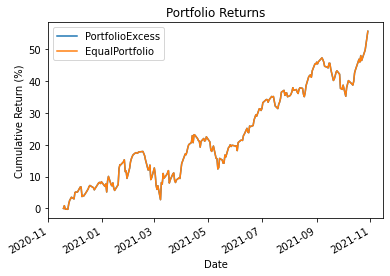

In [4]:

# Excess portfolio returns compared to equal-weighted portfolio returns
# In this case, the lines overlap because risk-free rate = 0
FamaFrench_data['PortfolioExcess'] = FamaFrench_data['EqualPortfolio'] - FamaFrench_data['RF']
cum_returns_df = ((1+FamaFrench_data).cumprod() - 1) * 100
cum_returns_df[['PortfolioExcess', 'EqualPortfolio']].plot()
plt.title('Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.show()

# CAPM Model 1

In [6]:

# CAPM highly dependent on beta, which is a measure of the portfolio's exposure to the broad market
# In an investment environment where the risk-free rate = 0, all returns are excess returns
# Therefore, it is more important to know your portfolio's exposure to the benchmark market (i.e. beta)
covariance_matrix = FamaFrench_data[['PortfolioExcess', 'MarketExcess']].cov()
print(covariance_matrix)

                 PortfolioExcess  MarketExcess
PortfolioExcess         0.000179      0.008520
MarketExcess            0.008520      0.685205


In [7]:
covariance_coefficient = covariance_matrix.iloc[0,1]

In [8]:
market_variance = FamaFrench_data['MarketExcess'].var()
print(market_variance)

0.6852050420168067


In [9]:
# For every 1% rise (fal) in the market, you can expect your portfolio to rise (fall) by this much
portfolio_beta = covariance_coefficient/market_variance
print("The portfolio beta is {:.2f}".format(portfolio_beta*100)+"%.")

The portfolio beta is 1.24%.


# CAPM Model 2

In [14]:

# This method of modelling the CAPM beta uses ordinary least squares regression
# It can easily be extended to incorporate more factors as well
model = smf.ols(formula='PortfolioExcess ~ MarketExcess', data=FamaFrench_data)
fitted_model = model.fit()
print(fitted_model.params)

Intercept       0.000576
MarketExcess    0.012434
dtype: float64


In [12]:

beta = fitted_model.params['MarketExcess']
print("The portfolio beta is {:.2f}".format(beta*100)+"%.")

The portfolio beta is 1.24%.


In [16]:

# How much of the regressed variable's variance is explained by the regressor factors?
# This is measured by the r^2 metric
r_sq = fitted_model.rsquared
print("The model's r-squared is {:.2f}".format(r_sq*100)+"%.")

The r-squared is 59.30%.


In [17]:

# How much of the regressed variable's variance is explained by the regressor factors?
# The adjusted-r^2 metric takes into account the number of factors in the model, which helps with overfitting
adjusted_r_sq = fitted_model.rsquared_adj
print("The model's adjusted r-squared is {:.2f}".format(adjusted_r_sq*100)+"%.")

The model's adjusted r-squared is 59.13%.
